# Large-area metalens

<!--  ![image.png =10x](img/metalens_drawing.png) -->
<!--  <img src="./img/metalens_drawing.png" alt="drawing" width="1000"/> -->

Run this notebook in your browser using [Binder](https://mybinder.org/v2/gh/flexcompute-readthedocs/tidy3d-docs/readthedocs?labpath=docs%2Fsource%2Fnotebooks%2FMetalens.ipynb).

## Introduction

Here we use Tidy3D to simulate a very large dielectric metalens.   We base this example off of the recent paper from Khorasaninejad et al. titled [_Metalenses at visible wavelengths: Diffraction-limited focusing and subwavelength resolution imaging_](https://science.sciencemag.org/content/352/6290/1190), which was recently published in Science.  In this paper, a 2-dimensional array of dielectric structures is used as a lens to focus transmitted light to a single position directly above the device.

Typically, these structures are simulated by simulating each dielectric unit cell individually to compute a phase and amplitude transmittance for each cell.  While this approach makes for an approximation of the overall device performance, it would be useful to be able to simulate the *entire* device as a whole to capture the entire physics.  However, a simulation of this scale requires several hours or days to do with a conventional CPU-based FDTD.  With Tidy3D, we are able to complete the entire simulation in about 1 minute!

## Setup

We first perform basic imports of the packages needed.

In [1]:
# standard python imports
import numpy as np
from numpy import random
import matplotlib.pyplot as plt

import tidy3d as td
from tidy3d import web

## Define Simulation Parameters

We now set the basic parameters that define the metalens.  The following image (taken from the original paper) define the variables describing the unit cell of the metalens.   The angle of each cell (θ) is chosen for maximum focusing effect.  Note that microns are the default spatial unit in Tidy3D.

<!-- ![image.png](img/metalens_diagram.png) -->
 <img src="img/metalens_diagram.png" alt="diagram" width="700"/>

In [2]:
# 1 nanometer in units of microns (for conversion)
nm = 1e-3

# free space central wavelength
wavelength = 600 * nm

# desired numerical aperture
NA = 0.5

# shape parameters of metalens unit cell (um) (refer to image above and see paper for details)
W = 85 * nm
L = 410 * nm
H = 600 * nm
S = 430 * nm

# space between bottom PML and substrate (-z)
space_below_sub = 1 * wavelength

# thickness of substrate
thickness_sub = 100 * nm

# side length of entire metalens (um)
side_length = 10

# Number of unit cells in each x and y direction (NxN grid)
N = int(side_length / S)
print(f'for diameter of {side_length:.1f} um, have {N} cells per side')
print(f'full metalens has area of {side_length**2:.1f} um^2 and {N*N} total cells')

# Define material properties at 600 nm
n_TiO2 = 2.40
n_SiO2 = 1.46
air = td.Medium(permittivity=1.0)
SiO2 = td.Medium(permittivity=n_SiO2**2)
TiO2 = td.Medium(permittivity=n_TiO2**2)

for diameter of 10.0 um, have 23 cells per side
full metalens has area of 100.0 um^2 and 529 total cells


## Process Geometry

Next we need to do conversions to get the problem parameters ready to define the simulation. We also define the grid based on the properties of the geometry. The metalens is quasi-periodic in x and y, in that we have clearly defined unit cells, but each is slightly modified from its neighbors. Such structures are best resolved with a grid that matches the periodicity, which is why we use a uniform grid in x and y. In z, we use the automatic nonuniform grid that will place a higher grid density around the metalens region, and a lower one in the air region away from the metalens.

In [3]:
# steps per unit cell along x and y
grids_per_unit_length = 20
# uniform mesh in x and y
grid_x = td.UniformGrid(dl=S / grids_per_unit_length)
grid_y = td.UniformGrid(dl=S / grids_per_unit_length)
# in z, use an automatic nonuniform mesh with the wavelength being the "unit length"
grid_z = td.AutoGrid(min_steps_per_wvl=grids_per_unit_length)
# we need to supply the wavelength because of the automatic mesh in z
grid_spec = td.GridSpec(wavelength=wavelength, grid_x=grid_x, grid_y=grid_y, grid_z=grid_z)

# using the wavelength in microns, one can use td.C_0 (um/s) to get frequency in Hz
# wavelength_meters = wavelength * meters
f0 = td.C_0 / wavelength

# Compute the domain size in x, y (note: round down from side_length)
length_xy = N * S

# focal length given diameter and numerical aperture
f = length_xy / 2 / NA * np.sqrt(1 - NA**2)

# Function describing the theoretical best angle of each box at position (x,y).  see paper for details
def theta(x, y):
    return np.pi / wavelength * (f - np.sqrt(x ** 2 + y ** 2 + f ** 2))

# total domain size in z: (space -> substrate -> unit cell -> 1.7 focal lengths)
length_z = space_below_sub + thickness_sub + H + 1.7 * f

# construct simulation size array
sim_size = (length_xy, length_xy, length_z)

## Create Metalens Geometry

Now we can automatically generate a large metalens structure using these parameters.

We will first create the substrate as a [td.Box](https://docs.simulation.cloud/en/latest/_autosummary/tidy3d.Box.html#tidy3d-box)

Then, we will loop through the x and y coordinates of the lens and create each unit cell as a [td.PolySlab](https://docs.simulation.cloud/en/latest/_autosummary/tidy3d.PolySlab.html#tidy3d-polyslab)

In [4]:
# define substrate
substrate = td.Structure(
    geometry=td.Box(
        center=[0, 0, -length_z/2 + space_below_sub + thickness_sub / 2.0],
        size=[td.inf, td.inf, thickness_sub],
    ),
    medium=SiO2
)

# define coordinates of each unit cell
centers_x = S * np.arange(N) - length_xy / 2.0 + S / 2.0
centers_y = S * np.arange(N) - length_xy / 2.0 + S / 2.0
center_z = -length_z/2 + space_below_sub + thickness_sub + H / 2.0

# x, y vertices of box of size (L, W) centered at the origin
vertices_origin = np.array([[+L/2, +W/2],
                            [-L/2, +W/2],
                            [-L/2, -W/2],
                            [+L/2, -W/2]])


xs, ys = np.meshgrid(centers_x, centers_y, indexing='ij')
xs = xs.flatten()
ys = ys.flatten()

angles = theta(xs, ys)

# 2x2 rotation matrix angle `angle` with respect to x axis
rotation_matrix = np.array([
    [+np.cos(angles), -np.sin(angles)],
    [+np.sin(angles), +np.cos(angles)]
])

# rotate the origin vertices by this angle
vertices_rotated = np.einsum('ij, jkn -> nik', vertices_origin, rotation_matrix)

# shift the rotated vertices to be centered at (xs, ys)
vertices_shifted = vertices_rotated + np.stack([xs, ys], axis=-1)[:, None, :]

metalens = []
for vertices in vertices_shifted:
    # create a tidy3D PolySlab with these rotated and shifted vertices and thickness `H`
    metalens.append(
        td.Structure(
            geometry=td.PolySlab(
                vertices=vertices.tolist(),
                slab_bounds=(center_z-H/2, center_z+H/2),
                axis=2),
            medium=TiO2
        )
    )


## Define Sources

Now we define the incident fields.  We simply use a normally incident plane wave with Guassian time dependence centered at our central frequency.  For more details, see the [plane wave source documentation](https://docs.simulation.cloud/en/latest/_autosummary/tidy3d.PlaneWave.html#tidy3d-planewave) and the [gaussian source documentation](https://docs.simulation.cloud/en/latest/_autosummary/tidy3d.GaussianPulse.html#tidy3d-gaussianpulse)

In [5]:
# Bandwidth in Hz
fwidth = f0 / 10.0

# time dependence of source
gaussian = td.GaussianPulse(freq0=f0, fwidth=fwidth, phase=0)

source = td.PlaneWave(
    source_time=gaussian,
    size=(td.inf, td.inf, 0),
    center=(0,0,-length_z/2 + space_below_sub / 10.0),
    direction='+',
    pol_angle=0)

run_time = 50 / fwidth

## Define Monitors

Now we define the monitors that measure field output from the FDTD simulation.  For simplicity, we use measure the fields at the central frequency.  We'll get the fields at the following locations:

- The y=0 cross section
- The x=0 cross section
- The z=f cross section at the focal plane
- The central axis, along x=y=0

For more details on defining monitors, see the [frequency-domain field monitor documentation](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.FieldMonitor.html).

In [6]:
# get fields along x=y=0 axis
monitor_center = td.FieldMonitor(
    center=[0., 0., 0],
    size=[0, 0, td.inf],
    freqs=[f0],
    name='center'
)

# get the fields at a few cross-sectional planes
monitor_xz = td.FieldMonitor(
    center=[0., 0., 0.],
    size=[td.inf, 0., td.inf],
    freqs=[f0],
    name='xz'
)

monitor_yz = td.FieldMonitor(
    center=[0., 0., 0.],
    size=[0., td.inf, td.inf],
    freqs=[f0],
    name='yz'
)

monitor_xy = td.FieldMonitor(
    center=[0., 0., center_z + H/2 + f],
    size=[td.inf, td.inf, 0],
    freqs=[f0],
    name='focal_plane'
)

# put them into a single list
monitors=[monitor_center, monitor_xz, monitor_yz, monitor_xy]

## Create Simulation

Now we can put everything together and define a [Simulation](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.Simulation.html) object to be run.



We get a number of warnings about structures being too close to the PML. In FDTD simulations, this can result in instability, as PML are absorbing for propagating fields, but can be amplifying for evanescent fields. This particular simulation runs without any issues even with PML on the sides, but it is best to heed these warnings to avoid problems. There are two ways that we can fix the simulation: one is to just put some space between the last of the metalens boxes and the PML. The other is to use adiabatic absorbers on the sides, which are always stable. The only downside of the absorbers is that they are slightly thicker than the PML, making the overall simulation size slighlty larger. This is why we only put them along x and y, while we leave the PML in z.

In [7]:
sim = td.Simulation(
    size=sim_size,
    grid_spec=grid_spec,
    structures=[substrate]+metalens,
    sources=[source],
    monitors=monitors,
    run_time=run_time,
    pml_layers=(td.Absorber(), td.Absorber(), td.PML()))

## Visualize Geometry

Lets take a look and make sure everything is defined properly


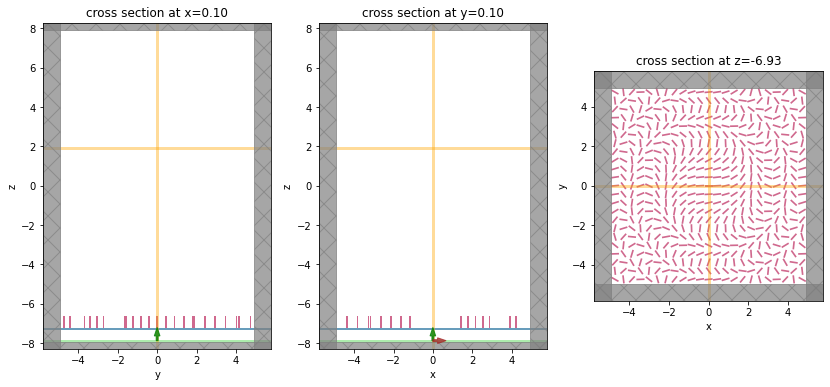

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 6))

# Time the visualization of the 2D plane
sim.plot(x=0.1, ax=ax1);
sim.plot(y=0.1, ax=ax2);
sim.plot(z=-length_z/2 + space_below_sub + thickness_sub + H / 2, ax=ax3);

## Run Simulation

Now we can run the simulation over time and measure the results to plot


In [9]:
job = web.Job(simulation=sim, task_name='metalens')
sim_data = job.run(path='data/simulation_data.hdf5')

[14:21:57] INFO     Using Tidy3D credentials from stored file                      ]8;id=155735;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/auth.py\auth.py]8;;\:]8;id=52239;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/auth.py#74\74]8;;\

[14:21:59] INFO     Uploaded task 'metalens' with task_id                       ]8;id=487479;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=670681;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#120\120]8;;\
                    '8f37f120-e0af-4758-b060-288c5c5d7654'.

[14:22:05] INFO     Maximum flex unit cost: 1.61                                ]8;id=43477;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=414331;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#141\141]8;;\

Output()

[14:22:18] INFO     status = queued                                             ]8;id=292150;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=752568;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#263\263]8;;\

[14:22:37] INFO     starting up solver                                          ]8;id=5414;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=647598;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#267\267]8;;\

[14:22:51] INFO     running solver                                              ]8;id=68770;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=477853;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#272\272]8;;\

Output()

[14:23:38] INFO     early shutoff detected, exiting.                            ]8;id=903531;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=508103;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#282\282]8;;\

% done (field decay = 1.80e-05) ━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━  28% 0:00:58

Output()

[14:23:41] INFO     status = postprocess                                        ]8;id=937039;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=617323;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#291\291]8;;\

[14:23:58] INFO     status = success                                            ]8;id=644517;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=359752;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#291\291]8;;\

[14:24:02] INFO     downloading file "monitor_data.hdf5" to                     ]8;id=994371;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=474591;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#522\522]8;;\
                    "data/simulation_data.hdf5"

Output()

Downloading... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

[14:24:06] INFO     loading SimulationData from data/simulation_data.hdf5       ]8;id=397101;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=710941;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#357\357]8;;\

In [10]:
print(sim_data.log)

Simulation domain Nx, Ny, Nz: [541, 541, 586]
Applied symmetries: (0, 0, 0)
Number of computational grid points: 1.7151e+08.
Using subpixel averaging: True
Number of time steps: 3.5415e+04
Automatic shutoff factor: 1.00e-05
Time step (s): 2.8258e-17

Compute source modes time (s):     1.4848
Compute monitor modes time (s):    0.7681

Starting solver...
- Time step    564 / time 1.59e-14s (  1 % done), field decay: 1.00e+00
- Time step   1416 / time 4.00e-14s (  4 % done), field decay: 8.78e-01
- Time step   2833 / time 8.01e-14s (  8 % done), field decay: 1.08e-01
- Time step   4249 / time 1.20e-13s ( 12 % done), field decay: 5.82e-03
- Time step   5666 / time 1.60e-13s ( 16 % done), field decay: 1.02e-03
- Time step   7082 / time 2.00e-13s ( 20 % done), field decay: 1.98e-04
- Time step   8499 / time 2.40e-13s ( 24 % done), field decay: 5.25e-05
- Time step   9916 / time 2.80e-13s ( 28 % done), field decay: 1.80e-05
- Time step  11332 / time 3.20e-13s ( 32 % done), field decay: 6.26e-

----

As we can see from the logs, the **total time to solve this problem (not including data transfer and pre/post-processing) was just several minutes!**

For reference, the same problem run with FDTD on a **single CPU core FDTD is projected to take 40 hours!**

## Visualize Fields

Let's see the results of the simulation as captured by our field monitors.

First, we look at the field intensity along the axis of the lens

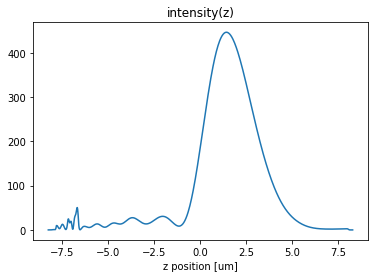

In [11]:
focal_z = center_z+H/2+f
data_center_line = sim_data.at_centers('center')
I = abs(data_center_line.Ex)**2 + abs(data_center_line.Ey)**2 + abs(data_center_line.Ez)**2
I.plot()
plt.title('intensity(z)')
plt.show()

We now can inspect the field patterns on the area monitors using the Tidy3D visualization nethods.

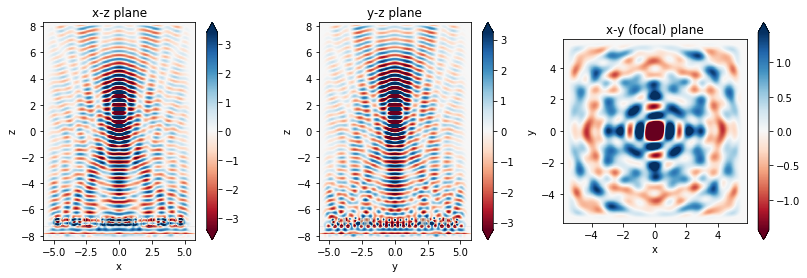

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
sim_data.plot_field('xz', 'Ex', val='real', freq=f0, y=0, ax=ax1)
sim_data.plot_field('yz', 'Ex', val='real', freq=f0, x=0, ax=ax2)
sim_data.plot_field('focal_plane', 'Ex', val='real', freq=f0, z=focal_z, ax=ax3)
ax1.set_title('x-z plane')
ax2.set_title('y-z plane')
ax3.set_title('x-y (focal) plane')
plt.show()


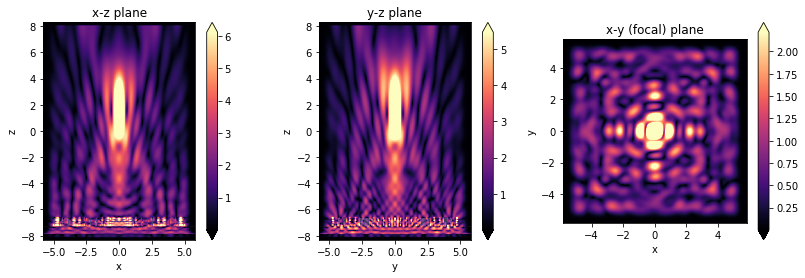

In [13]:
# plot absolute value for good measure
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
sim_data.plot_field('xz', 'Ex', val='abs', freq=f0, y=0, ax=ax1)
sim_data.plot_field('yz', 'Ex', val='abs', freq=f0, x=0, ax=ax2)
sim_data.plot_field('focal_plane', 'Ex', val='abs', freq=f0, z=focal_z, ax=ax3)
ax1.set_title('x-z plane')
ax2.set_title('y-z plane')
ax3.set_title('x-y (focal) plane')
plt.show()

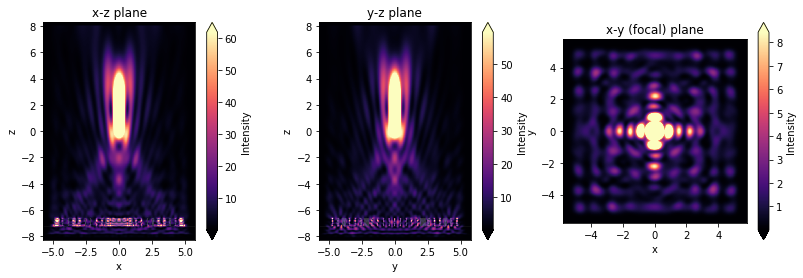

In [14]:
# and lets plot the intensites as well
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
sim_data.plot_field('xz', 'int', freq=f0, y=0, ax=ax1)
sim_data.plot_field('yz', 'int', freq=f0, x=0, ax=ax2)
sim_data.plot_field('focal_plane', 'int', freq=f0, z=focal_z, ax=ax3)
ax1.set_title('x-z plane')
ax2.set_title('y-z plane')
ax3.set_title('x-y (focal) plane')
plt.show()

